In [483]:
import math
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_docs.plots
import tensorflow_docs.modeling
import tensorflow_docs as tfdocs

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.backend import clear_session
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

## Data Import & Preparation

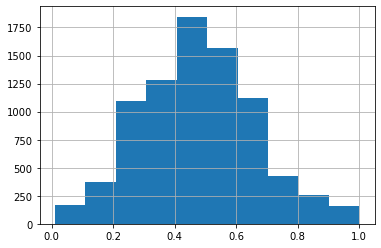

In [474]:
df = pd.read_csv('data.csv')
df = df.drop(['raw', 'meditation', 'delta', 'low-gamma', 'mid-gamma'], axis=1)
df.attention = df.attention / 100

df.attention.hist()

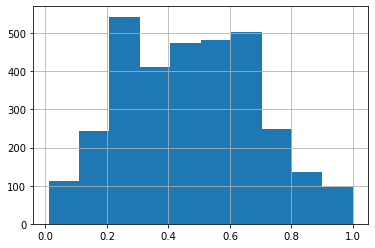

In [476]:
def remove_outliers(df):
    out = pd.DataFrame()
    for att in df.attention.unique():
        tmp_df = df[df.attention == att]
        tmp = []
        for col in tmp_df.columns[1:]:
            Q1 = tmp_df[col].quantile(0.25)
            Q3 = tmp_df[col].quantile(0.75)
            tmp += [(col, Q1, Q3)]
        for col, Q1, Q3 in tmp:
            IQR = Q3 - Q1
            tmp_df = tmp_df[(tmp_df[col] >= Q1 - 1.5 * IQR) & (tmp_df[col] <= Q3 + 1.5 * IQR)]
        out = pd.concat([out, tmp_df])
    return out

def extract_features(df):
    for col in ['theta', 'low-alpha', 'high-alpha', 'low-beta', 'high-beta']:
        df[f'log2-{col}'] = np.log2(df[col])
    return df

def prepare_data(df):
    df = remove_outliers(df)
    df = df.sample(frac=1).reset_index(drop=True)
    df = df.groupby(df.attention).head(100)
    df = extract_features(df)
    return df

df = prepare_data(df)
df.attention.hist()

In [484]:
def train_val_test_split(df, val_size=0.2, test_size=0.2):
    n = len(df)
    df = df.sample(frac=1).reset_index(drop=True)
    val = df.groupby('attention').apply(lambda x: x.head(int(n * val_size)))
    test = df.groupby('attention').apply(lambda x: x.tail(int(n * test_size)))

    X = np.array(df.drop('attention', axis=1))
    y = np.array(df[['attention']])

    scaler = MinMaxScaler()
    X = scaler.fit_transform(X)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2598, 10), (650, 10), (2598, 1), (650, 1))

## Model

In [491]:
def build_model():
    clear_session()
    model = Sequential()
    model.add(Dense(16, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(Dense(8, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))

    # optimizer = Adam(1e-2)
    optimizer = RMSprop(1e-2)
    model.compile(optimizer=optimizer, loss='mae', metrics=['mae', 'mse'])
    return model

model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                176       
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 136       
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 321
Trainable params: 321
Non-trainable params: 0
_________________________________________________________________


In [492]:
es = EarlyStopping(monitor='val_loss', mode='min', patience=40, verbose=0)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=15, min_lr=0)
history = model.fit(X_train, y_train, epochs=1000, validation_split=0.2, batch_size=16, callbacks=[es, reduce_lr], verbose=2)

Epoch 1/1000
130/130 - 0s - loss: 0.1646 - mae: 0.1646 - mse: 0.0404 - val_loss: 0.1561 - val_mae: 0.1561 - val_mse: 0.0372 - lr: 0.0100
Epoch 2/1000
130/130 - 0s - loss: 0.1467 - mae: 0.1467 - mse: 0.0336 - val_loss: 0.1375 - val_mae: 0.1375 - val_mse: 0.0282 - lr: 0.0100
Epoch 3/1000
130/130 - 0s - loss: 0.1411 - mae: 0.1411 - mse: 0.0315 - val_loss: 0.1364 - val_mae: 0.1364 - val_mse: 0.0285 - lr: 0.0100
Epoch 4/1000
130/130 - 0s - loss: 0.1422 - mae: 0.1422 - mse: 0.0319 - val_loss: 0.1310 - val_mae: 0.1310 - val_mse: 0.0264 - lr: 0.0100
Epoch 5/1000
130/130 - 0s - loss: 0.1405 - mae: 0.1405 - mse: 0.0313 - val_loss: 0.1309 - val_mae: 0.1309 - val_mse: 0.0263 - lr: 0.0100
Epoch 6/1000
130/130 - 0s - loss: 0.1407 - mae: 0.1407 - mse: 0.0309 - val_loss: 0.1377 - val_mae: 0.1377 - val_mse: 0.0290 - lr: 0.0100
Epoch 7/1000
130/130 - 0s - loss: 0.1392 - mae: 0.1392 - mse: 0.0301 - val_loss: 0.1312 - val_mae: 0.1312 - val_mse: 0.0262 - lr: 0.0100
Epoch 8/1000
130/130 - 0s - loss: 0.1391 

Text(0, 0.5, 'Loss (MAE)')

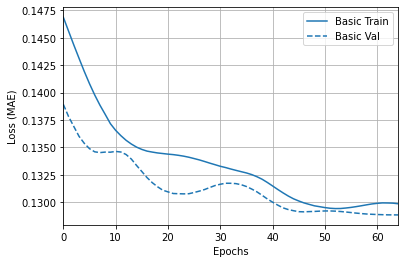

In [493]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)

plotter.plot({'Basic': history}, metric="mae")
plt.ylabel('Loss (MAE)')

## Prediction

In [494]:
loss, mae, mse = model.evaluate(X_test, y_test, verbose=2)

21/21 - 0s - loss: 0.1252 - mae: 0.1252 - mse: 0.0251


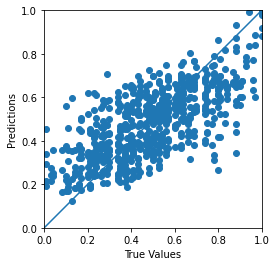

In [495]:
y_pred = model.predict(X_test).flatten()

a = plt.axes(aspect='equal')
plt.scatter(y_test, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
lims = [0, 1]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)
